<a href="https://colab.research.google.com/github/balvantchauhan/Deep-Learning/blob/main/Transfer_learning_and_fine_tuning.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

## Transfer Learning and Fine Tuning

We will learn how to classify images of cats and dogs by using transfer learning from a pre-trained network.


A pre-trained model is a saved network that was previously trained on a large dataset, typically on a large-scale image-classification task. We either use the pretrained model as is or use transfer learning to customize this model to a given task.

The intuition behind transfer learning for image classification is that if a model is trained on a large and general enough dataset, this model will effectively serve as a generic model of the visual world. We can then take advantage of these learned feature maps without having to start from scratch by training a large model on a large dataset.

In this notebook, you will try two ways to customize a pretrained model:

- __Feature Extraction__: Use the representations learned by a previous network to extract meaningful features from new samples. You simply add a new classifier, which will be trained from scratch, on top of the pretrained model so that you can repurpose the feature maps learned previously for the dataset.

We do not need to (re)train the entire model. The base convolutional network already contains features that are generically useful for classifying pictures. However, the final, classification part of the pretrained model is specific to the original classification task, and subsequently specific to the set of classes on which the model was trained.

- __Fine-Tuning__: Unfreeze a few of the top layers of a frozen model base and jointly train both the newly-added classifier layers and the last layers of the base model. This allows us to "fine-tune" the higher-order feature representations in the base model in order to make them more relevant for the specific task.

We will follow the general machine learning workflow.
- Examine and understand the data
- Build an input pipeline, in this case using Keras ImageDataGenerator
- Compose the model
- Load in the pretrained base model (and pretrained weights)
- Stack the classification layers on top
- Train the model
- Evaluate model

### Import Requrired Library 

In [32]:
import matplotlib.pyplot as plt
import numpy as np
import os
import tensorflow as tf
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers.experimental.preprocessing import RandomFlip, RandomRotation
from tensorflow.keras.preprocessing import image_dataset_from_directory
from tensorflow.keras.applications.mobilenet_v2 import preprocess_input
from tensorflow.keras.applications import MobileNetV2
from tensorflow.keras.layers import GlobalAveragePooling2D, Input, Dropout

### Data Preprocessing

##### Data download



In this problem, we will use a dataset containing several thousand images of cats and dogs. Download and extract the images, then create a tf.data.Dataset for training and validation using the tf.keras.preprocessing.image_dataset_from_directory utility.

In [ ]:
URL = 'https://storage.googleapis.com/mledu-datasets/cats_and_dogs_filtered.zip'
path_to_zip = tf.keras.utils.get_file('cats_and_dogs.zip', origin=URL, extract=True)
PATH = os.path.join(os.path.dirname(path_to_zip), 'cats_and_dogs_filtered')

68608000/68606236 [==============================] - 0s 0us/step


In [ ]:
train_dir = os.path.join(PATH, 'train')
validation_dir = os.path.join(PATH, 'validation')

##### Create some other parameters for the loader

In [ ]:
BATCH_SIZE = 32
IMG_SIZE = (160, 160)

In [ ]:
train_dataset = image_dataset_from_directory(train_dir,
                                             shuffle=True,
                                             batch_size=BATCH_SIZE,
                                             image_size=IMG_SIZE)

Found 2000 files belonging to 2 classes.


In [ ]:
validation_dataset = image_dataset_from_directory(validation_dir,
                                                  shuffle=True,
                                                  batch_size=BATCH_SIZE,
                                                  image_size=IMG_SIZE)

Found 1000 files belonging to 2 classes.


Let's show the first 9 images and labels from training set

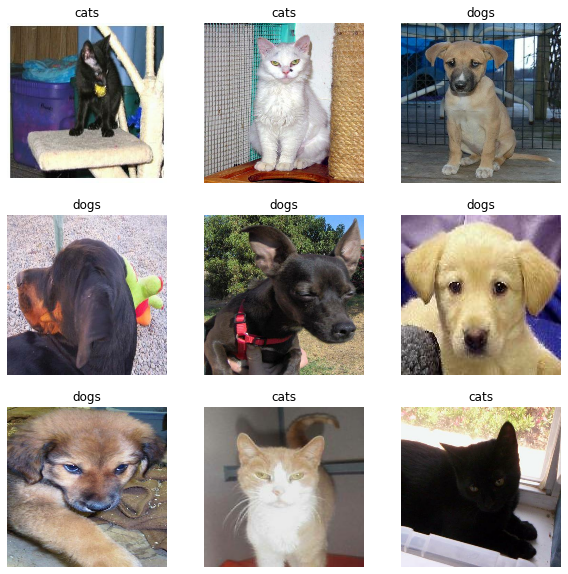

In [ ]:
class_names = train_dataset.class_names

plt.figure(figsize=(10, 10))
for images, label in train_dataset.take(1):
  for i in range(9):
    plt.subplot(3, 3, i + 1)
    plt.imshow(images[i].numpy().astype('uint8'))
    plt.title(class_names[label[i]])
    plt.axis('off')

As the original dataset doesn't contain a test set, you will create one. To do so, determine how many batches of data are available in the validation set using tf.data.experimental.cardinality, then move 20% of them to a test set.

In [ ]:
val_batches = tf.data.experimental.cardinality(validation_dataset)
test_dataset = validation_dataset.take(val_batches // 5)
validation_dataset = validation_dataset.skip(val_batches // 5)

In [ ]:
print('Number of validation batches: %d' % tf.data.experimental.cardinality(validation_dataset))
print('Number of test batches: %d' % tf.data.experimental.cardinality(test_dataset))

Number of validation batches: 26
Number of test batches: 6


#### Configure the dataset for performance

Use buffered prefetching to load images from disk without having I/O become blocking.

In [ ]:
AUTOTUNE = tf.data.AUTOTUNE

train_dataset = train_dataset.prefetch(buffer_size=AUTOTUNE)
validation_dataset = validation_dataset.prefetch(buffer_size=AUTOTUNE)
test_dataset = test_dataset.prefetch(buffer_size=AUTOTUNE)

### Data 


When we don't have a large image dataset, it's a good practice to artificially introduce sample diversity by applying random, yet realistic, transformations to the training images, such as rotation and horizontal flipping. This helps expose the model to different aspects of the training data and reduce overfitting.



In [ ]:
data_augmentation = Sequential()
data_augmentation.add(RandomFlip('horizontal'))
data_augmentation.add(RandomRotation(0.2))


Let's repeatedly apply these layers to the same image and see the result.

(1, 160, 160, 3)
(32, 160, 160, 3)
(1, 160, 160, 3)
(32, 160, 160, 3)
(1, 160, 160, 3)
(32, 160, 160, 3)
(1, 160, 160, 3)
(32, 160, 160, 3)
(1, 160, 160, 3)
(32, 160, 160, 3)
(1, 160, 160, 3)
(32, 160, 160, 3)
(1, 160, 160, 3)
(32, 160, 160, 3)
(1, 160, 160, 3)
(32, 160, 160, 3)
(1, 160, 160, 3)
(32, 160, 160, 3)


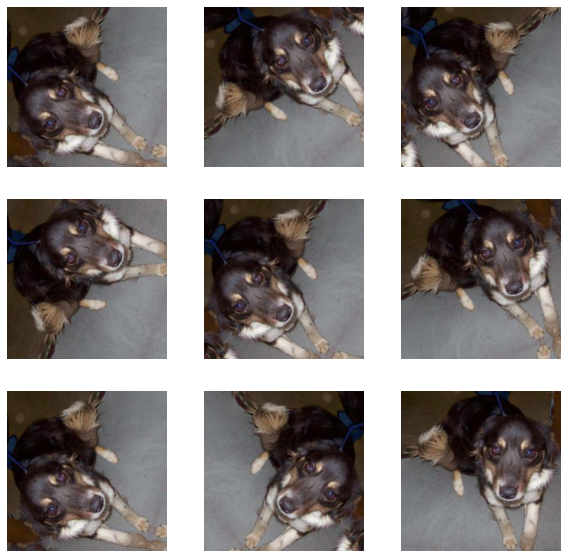

In [ ]:
for image, label in train_dataset.take(1):
  plt.figure(figsize=(10, 10))
  first_image = image[0]
  for i in range(9):
    plt.subplot(3, 3, i + 1)
    augmented_image = data_augmentation(tf.expand_dims(first_image, 0))
    plt.imshow(augmented_image[0] / 255)
    plt.axis('off')

### Rescale pixel values

In a moment, you will download tf.keras.applications.MobileNetV2 for use as your base model. This model expects pixel values in [-1, 1], but at this point, the pixel values in your images are in [0, 255]. To rescale them, use the preprocessing method included with the model.

In [18]:
preprocess_input = preprocess_input

### Create the base model from the pre-trained convnets

We will create the base model from the MobileNet V2 model developed at Google. This is pre-trained on the ImageNet dataset, a large dataset consisting of 1.4M images and 1000 classes. ImageNet is a research training dataset with a wide variety of categories like jackfruit and syringe. This base of knowledge will help us classify cats and dogs from our specific dataset.

First, we need to pick which layer of MobileNet V2 we will use for feature extraction. The very last classification layer (on "top", as most diagrams of machine learning models go from bottom to top) is not very useful. Instead, you will follow the common practice to depend on the very last layer before the flatten operation. This layer is called the "bottleneck layer". The bottleneck layer features retain more generality as compared to the final/top layer.

First, instantiate a MobileNet V2 model pre-loaded with weights trained on ImageNet. By specifying the include_top=False argument, you load a network that doesn't include the classification layers at the top, which is ideal for feature extraction.

In [21]:
# Create the base model from the pre-trained model MobileNet V2
IMG_SHAPE = IMG_SIZE + (3,)
base_model = MobileNetV2(input_shape=IMG_SHAPE,
                          include_top=False,
                          weights='imagenet')

This feature extractor converts each 160x160x3 image into a 5x5x1280 block of features. Let's see what it does to an example batch of images:




In [22]:
image_batch, label_batch = next(iter(train_dataset))
feature_batch = base_model(image_batch)
print(feature_batch.shape)

(32, 5, 5, 1280)


### Feature extraction

In this step, we will freeze the convolutional base created from the previous step and to use as a feature extractor. Additionally, you add a classifier on top of it and train the top-level classifier.

##### Freeze the convolutional base


It is important to freeze the convolutional base before you compile and train the model. Freezing (by setting layer.trainable = False) prevents the weights in a given layer from being updated during training. MobileNet V2 has many layers, so setting the entire model's trainable flag to False will freeze all of them.

In [23]:
base_model.trainable = False

### Important note about BatchNormalization layers


Many models contain tf.keras.layers.BatchNormalization layers. This layer is a special case and precautions should be taken in the context of fine-tuning, as shown later in this tutorial.

When we set layer.trainable = False, the BatchNormalization layer will run in inference mode, and will not update its mean and variance statistics.

When you unfreeze a model that contains BatchNormalization layers in order to do fine-tuning, you should keep the BatchNormalization layers in inference mode by passing training = False when calling the base model. Otherwise, the updates applied to the non-trainable weights will destroy what the model has learned.

In [24]:
# Let's take a look at the base model architecture
base_model.summary()

Model: "mobilenetv2_1.00_160"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_2 (InputLayer)            [(None, 160, 160, 3) 0                                            
__________________________________________________________________________________________________
Conv1 (Conv2D)                  (None, 80, 80, 32)   864         input_2[0][0]                    
__________________________________________________________________________________________________
bn_Conv1 (BatchNormalization)   (None, 80, 80, 32)   128         Conv1[0][0]                      
__________________________________________________________________________________________________
Conv1_relu (ReLU)               (None, 80, 80, 32)   0           bn_Conv1[0][0]                   
_______________________________________________________________________________

### Add a classification head


To generate predictions from the block of features, average over the spatial 5x5 spatial locations, using a tf.keras.layers.GlobalAveragePooling2D layer to convert the features to a single 1280-element vector per image.

In [29]:
global_average_layer = GlobalAveragePooling2D()
feature_batch_average = global_average_layer(feature_batch)
print(feature_batch_average.shape)

(32, 1280)


Apply a tf.keras.layers.Dense layer to convert these features into a single prediction per image. You don't need an activation function here because this prediction will be treated as a logit, or a raw prediction value. Positive numbers predict class 1, negative numbers predict class 0.

In [30]:
prediction_layer = tf.keras.layers.Dense(1)
prediction_batch = prediction_layer(feature_batch_average)
print(prediction_batch.shape)

(32, 1)


Build a model by chaining together the data augmentation, rescaling, base_model and feature extractor layers using the Keras Functional API. As previously mentioned, use training=False as our model contains a BatchNormalization layer.

In [34]:
inputs = Input(shape=(160, 160, 3))
x = data_augmentation(inputs)
x = preprocess_input(x)
x = base_model(x, training=False)
x = global_average_layer(x)
x = Dropout(0.2)(x)
outputs = prediction_layer(x)
model = tf.keras.Model(inputs, outputs)

### Compile the model

Compile the model before training it. Since there are two classes, use a binary cross-entropy loss with from_logits=True since the model provides a linear output.

In [36]:
base_learning_rate = 0.0001
model.compile(optimizer=tf.keras.optimizers.Adam(learning_rate=base_learning_rate),
              loss=tf.keras.losses.BinaryCrossentropy(from_logits=True),
              metrics=['accuracy'])

In [37]:
model.summary()

Model: "model"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_3 (InputLayer)         [(None, 160, 160, 3)]     0         
_________________________________________________________________
sequential (Sequential)      (None, 160, 160, 3)       0         
_________________________________________________________________
tf.math.truediv (TFOpLambda) (None, 160, 160, 3)       0         
_________________________________________________________________
tf.math.subtract (TFOpLambda (None, 160, 160, 3)       0         
_________________________________________________________________
mobilenetv2_1.00_160 (Functi (None, 5, 5, 1280)        2257984   
_________________________________________________________________
global_average_pooling2d_1 ( (None, 1280)              0         
_________________________________________________________________
dropout (Dropout)            (None, 1280)              0     

The 2.5M parameters in MobileNet are frozen, but there are 1.2K trainable parameters in the Dense layer. These are divided between two tf.Variable objects, the weights and biases.




In [38]:
len(model.trainable_variables)

2

### Train the model

After training for 10 epochs, you should see ~94% accuracy on the validation set.

In [39]:
initial_epochs = 10

loss0, accuracy0 = model.evaluate(validation_dataset)

26/26 [==============================] - 2s 22ms/step - loss: 1.0366 - accuracy: 0.3787


In [40]:
print("initial loss: {:.2f}".format(loss0))
print("initial accuracy: {:.2f}".format(accuracy0))

initial loss: 1.04
initial accuracy: 0.38


In [41]:
history = model.fit(train_dataset,
                    epochs=initial_epochs,
                    validation_data=validation_dataset)

Epoch 1/10
63/63 [==============================] - 5s 34ms/step - loss: 0.8672 - accuracy: 0.4880 - val_loss: 0.6881 - val_accuracy: 0.6015
Epoch 2/10
63/63 [==============================] - 2s 33ms/step - loss: 0.6328 - accuracy: 0.6570 - val_loss: 0.4966 - val_accuracy: 0.7475
Epoch 3/10
63/63 [==============================] - 2s 33ms/step - loss: 0.5054 - accuracy: 0.7365 - val_loss: 0.3802 - val_accuracy: 0.8391
Epoch 4/10
63/63 [==============================] - 2s 33ms/step - loss: 0.4177 - accuracy: 0.7910 - val_loss: 0.3073 - val_accuracy: 0.8824
Epoch 5/10
63/63 [==============================] - 2s 33ms/step - loss: 0.3509 - accuracy: 0.8315 - val_loss: 0.2627 - val_accuracy: 0.8998
Epoch 6/10
63/63 [==============================] - 2s 33ms/step - loss: 0.3195 - accuracy: 0.8470 - val_loss: 0.2236 - val_accuracy: 0.9084
Epoch 7/10
63/63 [==============================] - 2s 34ms/step - loss: 0.2883 - accuracy: 0.8675 - val_loss: 0.1972 - val_accuracy: 0.9233
Epoch 8/10
63

### Learning curves


Let's take a look at the learning curves of the training and validation accuracy/loss when using the MobileNet V2 base model as a fixed feature extractor.

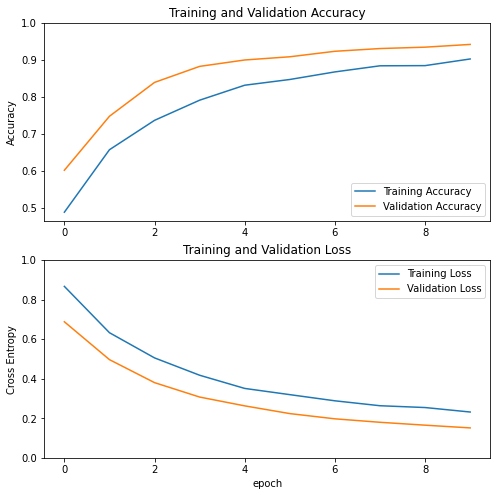

In [42]:
acc = history.history['accuracy']
val_acc = history.history['val_accuracy']

loss = history.history['loss']
val_loss = history.history['val_loss']

plt.figure(figsize=(8, 8))
plt.subplot(2, 1, 1)
plt.plot(acc, label='Training Accuracy')
plt.plot(val_acc, label='Validation Accuracy')
plt.legend(loc='lower right')
plt.ylabel('Accuracy')
plt.ylim([min(plt.ylim()),1])
plt.title('Training and Validation Accuracy')

plt.subplot(2, 1, 2)
plt.plot(loss, label='Training Loss')
plt.plot(val_loss, label='Validation Loss')
plt.legend(loc='upper right')
plt.ylabel('Cross Entropy')
plt.ylim([0,1.0])
plt.title('Training and Validation Loss')
plt.xlabel('epoch')
plt.show()

To a lesser extent, it is also because training metrics report the average for an epoch, while validation metrics are evaluated after the epoch, so validation metrics see a model that has trained slightly longer.



### Fine tuning


In the feature extraction experiment, we were only training a few layers on top of an MobileNet V2 base model. The weights of the pre-trained network were not updated during training.

One way to increase performance even further is to train (or "fine-tune") the weights of the top layers of the pre-trained model alongside the training of the classifier we added. The training process will force the weights to be tuned from generic feature maps to features associated specifically with the dataset.


Also, we should try to fine-tune a small number of top layers rather than the whole MobileNet model. In most convolutional networks, the higher up a layer is, the more specialized it is. The first few layers learn very simple and generic features that generalize to almost all types of images. As we go higher up, the features are increasingly more specific to the dataset on which the model was trained. The goal of fine-tuning is to adapt these specialized features to work with the new dataset, rather than overwrite the generic learning.


### Un-freeze the top layers of the model


All we need to do is unfreeze the base_model and set the bottom layers to be un-trainable. Then, we should recompile the model (necessary for these changes to take effect), and resume training.

In [43]:
base_model.trainable = True

In [44]:
# Let's take a look to see how many layers are in the base model
print("Number of layers in the base model: ", len(base_model.layers))

# Fine-tune from this layer onwards
fine_tune_at = 100

# Freeze all the layers before the `fine_tune_at` layer
for layer in base_model.layers[:fine_tune_at]:
  layer.trainable =  False

Number of layers in the base model:  154


### Compile the model


As we are training a much larger model and want to readapt the pretrained weights, it is important to use a lower learning rate at this stage. Otherwise, your model could overfit very quickly.

In [46]:
model.compile(loss=tf.keras.losses.BinaryCrossentropy(from_logits=True),
              optimizer = tf.keras.optimizers.RMSprop(learning_rate=base_learning_rate/10),
              metrics=['accuracy'])

In [47]:
model.summary()

Model: "model"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_3 (InputLayer)         [(None, 160, 160, 3)]     0         
_________________________________________________________________
sequential (Sequential)      (None, 160, 160, 3)       0         
_________________________________________________________________
tf.math.truediv (TFOpLambda) (None, 160, 160, 3)       0         
_________________________________________________________________
tf.math.subtract (TFOpLambda (None, 160, 160, 3)       0         
_________________________________________________________________
mobilenetv2_1.00_160 (Functi (None, 5, 5, 1280)        2257984   
_________________________________________________________________
global_average_pooling2d_1 ( (None, 1280)              0         
_________________________________________________________________
dropout (Dropout)            (None, 1280)              0     

In [48]:
len(model.trainable_variables)

56

### Continue training the model


If you trained to convergence earlier, this step will improve your accuracy by a few percentage points.

In [49]:
fine_tune_epochs = 10
total_epochs =  initial_epochs + fine_tune_epochs

history_fine = model.fit(train_dataset,
                         epochs=total_epochs,
                         initial_epoch=history.epoch[-1],
                         validation_data=validation_dataset)

Epoch 10/20
63/63 [==============================] - 8s 51ms/step - loss: 0.1495 - accuracy: 0.9310 - val_loss: 0.0637 - val_accuracy: 0.9802
Epoch 11/20
63/63 [==============================] - 3s 41ms/step - loss: 0.1189 - accuracy: 0.9500 - val_loss: 0.0495 - val_accuracy: 0.9827
Epoch 12/20
63/63 [==============================] - 3s 41ms/step - loss: 0.1106 - accuracy: 0.9555 - val_loss: 0.0592 - val_accuracy: 0.9851
Epoch 13/20
63/63 [==============================] - 3s 41ms/step - loss: 0.0965 - accuracy: 0.9665 - val_loss: 0.0366 - val_accuracy: 0.9864
Epoch 14/20
63/63 [==============================] - 3s 41ms/step - loss: 0.0983 - accuracy: 0.9545 - val_loss: 0.0439 - val_accuracy: 0.9790
Epoch 15/20
63/63 [==============================] - 3s 41ms/step - loss: 0.0718 - accuracy: 0.9680 - val_loss: 0.0471 - val_accuracy: 0.9839
Epoch 16/20
63/63 [==============================] - 3s 41ms/step - loss: 0.0866 - accuracy: 0.9665 - val_loss: 0.0320 - val_accuracy: 0.9876
Epoch 

Let's take a look at the learning curves of the training and validation accuracy/loss when fine-tuning the last few layers of the MobileNet V2 base model and training the classifier on top of it. The validation loss is much higher than the training loss, so you may get some overfitting.

we may also get some overfitting as the new training set is relatively small and similar to the original MobileNet V2 datasets.

After fine tuning the model nearly reaches 99% accuracy on the validation set.

In [50]:
acc += history_fine.history['accuracy']
val_acc += history_fine.history['val_accuracy']

loss += history_fine.history['loss']
val_loss += history_fine.history['val_loss']

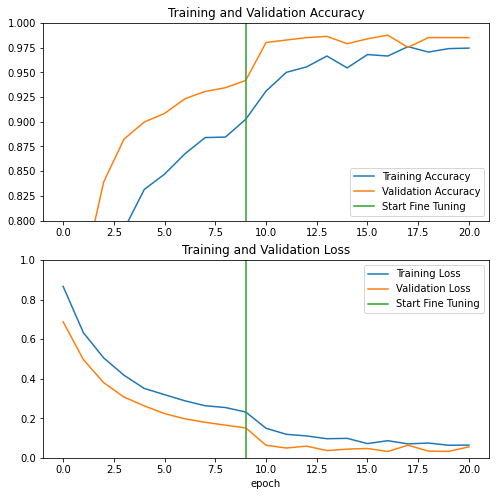

In [51]:
plt.figure(figsize=(8, 8))
plt.subplot(2, 1, 1)
plt.plot(acc, label='Training Accuracy')
plt.plot(val_acc, label='Validation Accuracy')
plt.ylim([0.8, 1])
plt.plot([initial_epochs-1,initial_epochs-1],
          plt.ylim(), label='Start Fine Tuning')
plt.legend(loc='lower right')
plt.title('Training and Validation Accuracy')

plt.subplot(2, 1, 2)
plt.plot(loss, label='Training Loss')
plt.plot(val_loss, label='Validation Loss')
plt.ylim([0, 1.0])
plt.plot([initial_epochs-1,initial_epochs-1],
         plt.ylim(), label='Start Fine Tuning')
plt.legend(loc='upper right')
plt.title('Training and Validation Loss')
plt.xlabel('epoch')
plt.show()

### Evaluation and prediction


Finaly you can verify the performance of the model on new data using test set.

In [52]:
loss, accuracy = model.evaluate(test_dataset)
print('Test accuracy :', accuracy)

6/6 [==============================] - 0s 23ms/step - loss: 0.0371 - accuracy: 0.9896
Test accuracy : 0.9895833134651184


And now you are all set to use this model to predict if your pet is a cat or dog.




Predictions:
 [0 1 0 1 0 0 0 0 0 1 0 1 0 1 1 1 0 1 1 0 0 1 1 1 0 0 0 1 1 0 1 1]
Label:
 [0 1 0 1 0 0 0 0 0 1 0 1 0 1 1 1 0 1 1 0 0 1 1 1 0 0 0 1 1 0 1 1]


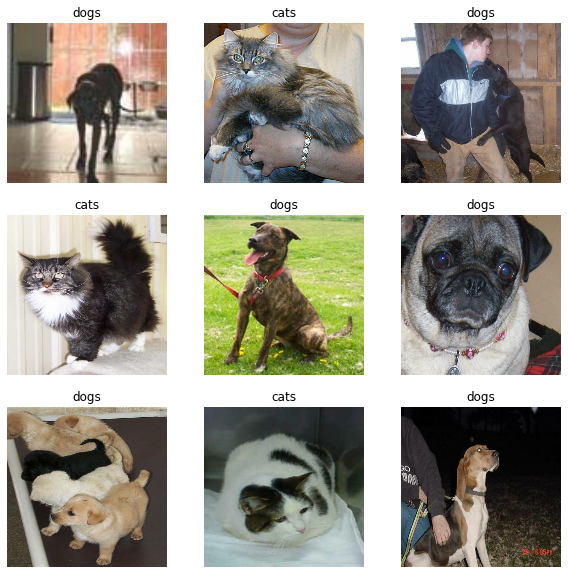

In [57]:
# Retrive a batch of images from the test set.
image_batch , label_batch = test_dataset.as_numpy_iterator().next()
preds = model.predict_on_batch(image_batch).flatten()

# apply a sigmoid since our model returns logits
preds = tf.nn.sigmoid(preds)
preds = tf.where(preds < 0.5, 0, 1)
print('Predictions:\n', preds.numpy())
print('Label:\n', label_batch)

plt.figure(figsize=(10, 10))
for i in range(9):
  plt.subplot(3, 3, i + 1)
  plt.imshow(image_batch[9 + i].astype('uint8'))
  plt.title(class_names[preds[9 + i]])
  plt.axis('off')

### Summary

- __Using a pre-trained model for feature extraction__: When working with a small dataset, it is a common practice to take advantage of features learned by a model trained on a larger dataset in the same domain. This is done by instantiating the pre-trained model and adding a fully-connected classifier on top. The pre-trained model is "frozen" and only the weights of the classifier get updated during training. In this case, the convolutional base extracted all the features associated with each image and you just trained a classifier that determines the image class given that set of extracted features.

- __Fine-tuning a pre-trained model__: To further improve performance, one might want to repurpose the top-level layers of the pre-trained models to the new dataset via fine-tuning. In this case, you tuned your weights such that your model learned high-level features specific to the dataset. This technique is usually recommended when the training dataset is large and very similar to the original dataset that the pre-trained model was trained on.